# Install libraries

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from tabulate import tabulate
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score,calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [3]:
df = pd.read_csv("dataset_cleaned.csv")
df = df.drop(axis=1, columns='Unnamed: 0')

# Clustering

## Input Preparation

In [4]:
df.columns

Index(['ID', 'Year_Of_Birth', 'Income', 'Registration_Time', 'Recency',
       'Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy', 'Jewellery',
       'Num_Deals_Purchases', 'Num_Web_Purchases', 'Num_Catalog_Purchases',
       'Num_Store_Purchases', 'Num_Web_Visits_Month', 'Promo_30', 'Promo_40',
       'Promo_50', 'Promo_10', 'Promo_20', 'Complain', 'Gender',
       'Total_Purchase', 'Payment_Method', 'Phone', 'Total_Expense', 'Age',
       'Marital_Status', 'Children', 'Family_Size', 'Is_Parent',
       'Academic_Level', 'Customer_For', 'Promo_Response'],
      dtype='object')

In [5]:
input_df = df[['Income', 'Recency', 'Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy', 'Jewellery','Num_Deals_Purchases', 'Num_Web_Purchases', 'Num_Catalog_Purchases','Num_Store_Purchases', 'Num_Web_Visits_Month', 'Complain', 'Total_Purchase', 'Total_Expense', 'Age', 'Marital_Status', 'Children', 'Family_Size', 'Is_Parent', 'Academic_Level', 'Customer_For', 'Promo_Response']]

In [6]:
input_df.head()

,Income,Recency,Liquor,Vegetables,Pork,Seafood,Candy,Jewellery,Num_Deals_Purchases,Num_Web_Purchases,...,Total_Purchase,Total_Expense,Age,Marital_Status,Children,Family_Size,Is_Parent,Academic_Level,Customer_For,Promo_Response
0,30396.0,22,16.0,2.0,6.0,0.0,1.0,12.0,2,1,...,6,37.0,42,Relationship,1,3,1,Post_Graduate,5184000000000000,1
1,68682.0,56,920.0,2.0,505.0,99.0,30.0,45.0,1,4,...,24,1601.0,42,Relationship,0,2,0,Post_Graduate,22982400000000000,0
2,63516.0,30,142.0,13.0,114.0,15.0,14.0,5.0,4,4,...,16,303.0,22,Relationship,2,4,1,Post_Graduate,30931200000000000,0
3,72679.0,65,620.0,56.0,260.0,127.0,54.0,54.0,1,4,...,17,1171.0,30,Single,1,2,1,Graduate,24537600000000000,0
4,66334.0,82,910.0,13.0,218.0,0.0,0.0,23.0,2,9,...,19,1164.0,37,Relationship,1,3,1,Post_Graduate,39052800000000000,0


### Label encoding for categorical variables

In [7]:
#Check categorical variables
check = (input_df.dtypes == 'object')
object_columns = list(check[check].index)

object_columns

['Marital_Status', 'Academic_Level']

In [8]:
label_encoder = LabelEncoder()
for i in object_columns:
    input_df[i]=input_df[[i]].apply(label_encoder.fit_transform)

### Standard Scaling

- Ensuring Fairness Among Variables: When variables in a dataset have different units or value ranges, a model might assess the importance of variables based on their value ranges. Standardizing the data ensures that each variable is evaluated on the same scale.

- Avoiding the Influence of Outliers: Variables with large value ranges can significantly affect the learning process of a model, especially for distance-based models like K-Means or DBSCAN. Standardizing the data helps minimize the impact of outliers by bringing all values into the same range.

- Enhancing Optimization Algorithm Performance: Some optimization algorithms, such as Gradient Descent, tend to perform more efficiently on variables that have the same value range. Standardizing the data helps in visualizing the optimization problem and accelerates the convergence speed of the algorithm.

- Suitability for Distance-Based Models: Distance-based clustering models like K-Means, DBSCAN, or Hierarchical clustering measure the distance between data points. Standardizing the data helps to unify the range of variables, thereby improving the performance of these models.

In [9]:
standard_scaler = StandardScaler()
standard_scaler.fit(input_df)
scaled_input_df = pd.DataFrame(standard_scaler.transform(input_df),columns=input_df.columns )

In [10]:
scaled_input_df.columns

Index(['Income', 'Recency', 'Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy',
       'Jewellery', 'Num_Deals_Purchases', 'Num_Web_Purchases',
       'Num_Catalog_Purchases', 'Num_Store_Purchases', 'Num_Web_Visits_Month',
       'Complain', 'Total_Purchase', 'Total_Expense', 'Age', 'Marital_Status',
       'Children', 'Family_Size', 'Is_Parent', 'Academic_Level',
       'Customer_For', 'Promo_Response'],
      dtype='object')

### PCA method

- Reducing Data Dimensions: PCA reduces the number of input variables while retaining most of the important information. This helps to lessen the computational load for Hierarchical and Agglomerative models, especially when the dataset is large.

- Eliminating Unimportant Variables While Retaining Crucial Information: In a large dataset, there may be variables that are unimportant or highly correlated with other variables. PCA helps eliminate these unimportant variables and retains only the principal components that have the greatest impact on data variability.

- Increasing Model Feasibility: By reducing the number of input variables, PCA can make Hierarchical and Agglomerative models easier to process and converge, especially when dealing with large datasets.

Trực quan hóa biểu đồ Scree Plot, biểu đồ này hiển thị phần trăm biến động được giải thích bởi mỗi thành phần chính. Trên biểu đồ, ta quan sát xem có một "cú đau" (elbow) ở một số lượng thành phần chính nào đó, tức là phần trăm biến động giải thích bởi các thành phần chính giảm đáng kể sau mỗi thành phần chính đó. Số lượng thành phần chính tại "cú đau" thường là một ước lượng tốt cho số lượng thành phần chính cần giữ lại.

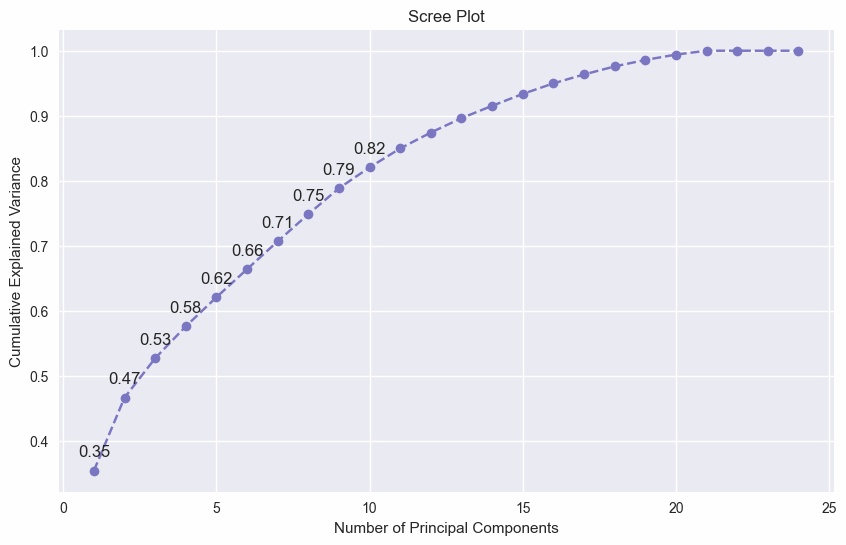

In [11]:
# Initialize the PCA model
pca_model = PCA()
# Fit the PCA model on the scaled input data
pca_model.fit(scaled_input_df)
# Extract the explained variance ratio by each principal component
explained_variance_ratio = pca_model.explained_variance_ratio_
# Calculate cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create a figure for the Scree Plot
plt.figure(figsize=(10, 6))
# Plot the cumulative explained variance ratio for each number of principal components
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
# Label the x-axis as 'Number of Principal Components'
plt.xlabel('Number of Principal Components')
# Label the y-axis as 'Cumulative Explained Variance'
plt.ylabel('Cumulative Explained Variance')
# Set the title of the plot to 'Scree Plot'
plt.title('Scree Plot')
# Add a grid for better readability
plt.grid(True)
# Annotate the cumulative explained variance for the first 10 principal components
for k in range(1, 11):
    plt.annotate(f"{cumulative_explained_variance[k-1]:.2f}", (k, cumulative_explained_variance[k-1]), textcoords="offset points", xytext=(0,10), ha='center')
# Display the plot
plt.show()

Ta chọn số principal components là 2

In [12]:
pca_model = PCA(n_components=2)
pca_model.fit(scaled_input_df)

PCA(n_components=2)

In [13]:
pca_result = pd.DataFrame(pca_model.transform(scaled_input_df), columns=(["d1","d2"]))
pca_result.describe().T

,count,mean,std,min,25%,50%,75%,max
d1,2228.0,8.291791e-17,2.916981,-5.527437,-2.652161,-0.799631,2.523671,7.647906
d2,2228.0,-1.267687e-16,1.642044,-4.094843,-1.141127,-0.231894,1.065992,6.849634


Ta thực hiện trực quan hóa dữ liệu để quan sát xu hướng của nó.

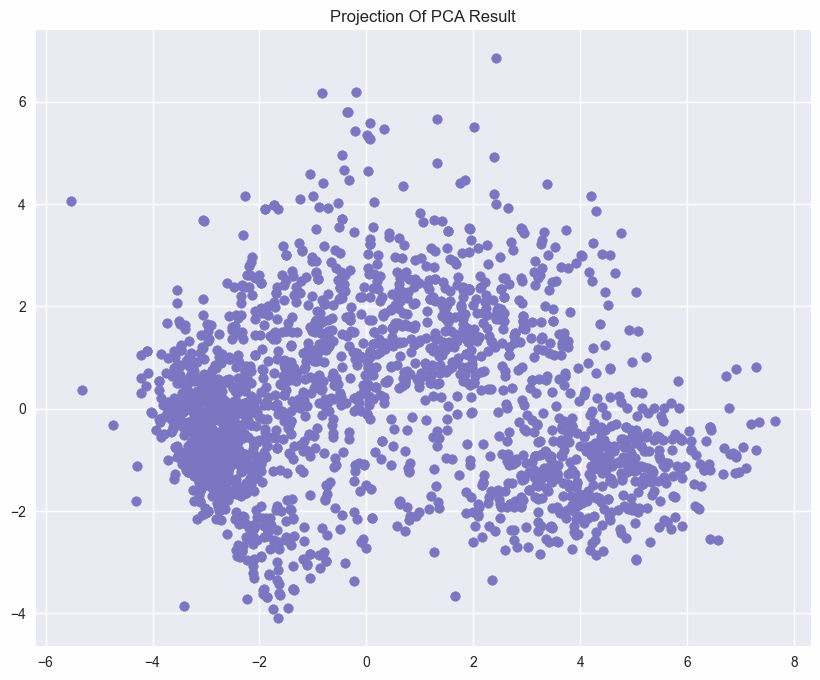

In [14]:
# 3D Projection
x = pca_result["d1"]
y = pca_result["d2"]
# z = pca_result["d3"]

fig = plt.figure(figsize=(10,8))
# ax = fig.add_subplot(111, projection="3d")
ax = fig.add_subplot(111)
ax.scatter(x,y, marker="o" )
ax.set_title("Projection Of PCA Result")
plt.show()

Ta thấy rằng dữ liệu phân phối thành các đám mây dày đặc nằm san sát nhau. Ngoài ra, we can see that there are some outliers flying around main cluster clouds.

### Model selection
| Model         | Cluster Characteristics     | Cluster Shape         | Cluster Density    | Noise    | Data Size         | Hierarchical Structure | Number of Clusters | Data Type |
|---------------|-----------------------------|-----------------------|--------------------|----------|-------------------|-----------------------|--------------------|------------|
| K-Means       | Spherical, similar size     | Spherical             | Uniform            | Low      | Medium            | No                    | Predefined         | Numeric and mixed data|
| DBSCAN        | Any, varying density        | Any                   | Non-uniform        | High     | Medium to large   | No                    | Doesn't need to be known |Numeric and mixed data|
| GMM           | Gaussian distribution, elliptical | Elliptical       | Uniform            | Low      | Medium            | No                    | Predefined         |Numeric and mixed data|
| Agglomerative | Hierarchical, undefined     | Any                   | Any                | Low      | Small to medium   | Yes                   | Doesn't need to be known |Numeric and mixed data|

GMM model maybe not suitable for the given dataset because of their Cluster Characteristics, Cluster Shape, and Cluster Density assumption. Then we are going to execute K-Means model and Agglomerative model and compare their effectiveness using below index:

1. **Inertia (Within-cluster Sum of Squares - WCSS)**
   - Measures the total squared distance from each point to its cluster center. A smaller value indicates tighter clusters. A lower Inertia value indicates that data points are closer to the centroid of their cluster, meaning the cluster has less dispersion.

2. **Silhouette Score**
   - Measures the similarity of points in the same cluster compared to points in other clusters. A value close to 1 indicates good clustering, close to 0 indicates overlapping clusters, and negative values indicate incorrect clustering.
   - Interpretation of Silhouette Score:
     - Close to 1: Points are correctly clustered, with small intra-cluster distance and large inter-cluster distance.
     - Close to 0: Points are close to the boundary between clusters.
     - Close to -1: Points might have been incorrectly clustered.

3. **Davies-Bouldin Index - DBI**
   - Evaluates the similarity between clusters. A smaller value indicates good clustering, with clusters having large distances between each other and points within the same cluster being close to each other.
   - Pros: Easy to compute and visually compare the similarity between clusters.
   - Cons: Sensitive to changes in data points and may not perform well with clusters of uneven shapes.

4. **Calinski-Harabasz Index (Variance Ratio Criterion) - CHI**
   - Measures the ratio of between-cluster dispersion and within-cluster dispersion. A higher value indicates good clustering, with clusters having large dispersion between them and small dispersion within them.
   - Pros: Easy to understand and visually compare the dispersion between and within clusters.
   - Cons: May not be suitable for data with complex or heterogeneous cluster shapes.



### Handle outliers
Using DBSCAN to detect outliers.

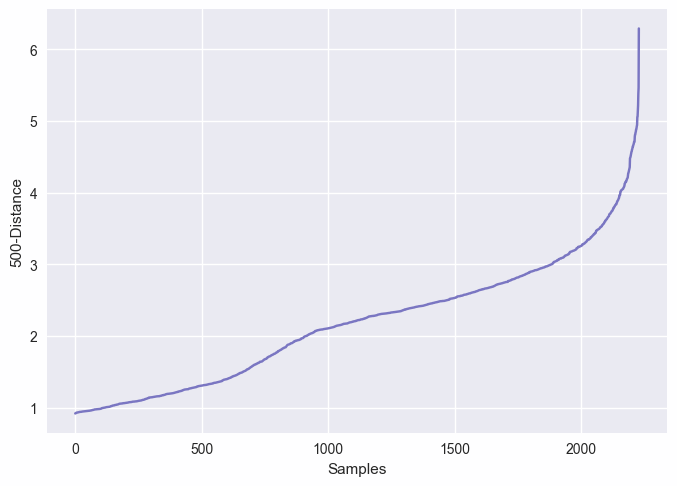

Suitable eps: 6.290060805928738
With min_samples = 200, number of clusters detected : 1
With min_samples = 300, number of clusters detected : 1
With min_samples = 400, number of clusters detected : 1
With min_samples = 500, number of clusters detected : 1


In [15]:
# Function calculate K-distance for each data point
def calculate_k_distance(data, k):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(data)
    distances, _ = neigh.kneighbors(data)
    return np.sort(distances[:, -1])

# Function find suitable epsilon bases on k-distance plot
def find_eps(data, min_samples, plot=False):
    k_distance = calculate_k_distance(data, min_samples)
    if plot:
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(k_distance)), k_distance)
        plt.xlabel('Samples')
        plt.ylabel(f'{min_samples}-Distance')
        plt.show()
    return np.sort(k_distance)[-1]

# Find suitable epsilon
eps = find_eps(pca_result, min_samples=500, plot=True)
print(f'Suitable eps: {eps}')

# Tunning min_samples
min_samples_list = [200, 300, 400, 500]
for min_samples in min_samples_list:
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_model.fit(pca_result)
    n_clusters = len(set(dbscan_model.labels_)) - (1 if -1 in dbscan_model.labels_ else 0)
    print(f'With min_samples = {min_samples}, number of clusters detected : {n_clusters}')


In [16]:
# Initiate DBSCAN model
dbscan_model = DBSCAN(eps=eps, min_samples=500)
dbscan_cluster_labels = dbscan_model.fit_predict(scaled_input_df)

pca_result['DBSCAN_Clusters'] = dbscan_cluster_labels
input_df['DBSCAN_Clusters'] = dbscan_cluster_labels
df['DBSCAN_Clusters'] = dbscan_cluster_labels

In [17]:
pca_result['DBSCAN_Clusters'].value_counts()

DBSCAN_Clusters
 0    2196
-1      32
Name: count, dtype: int64

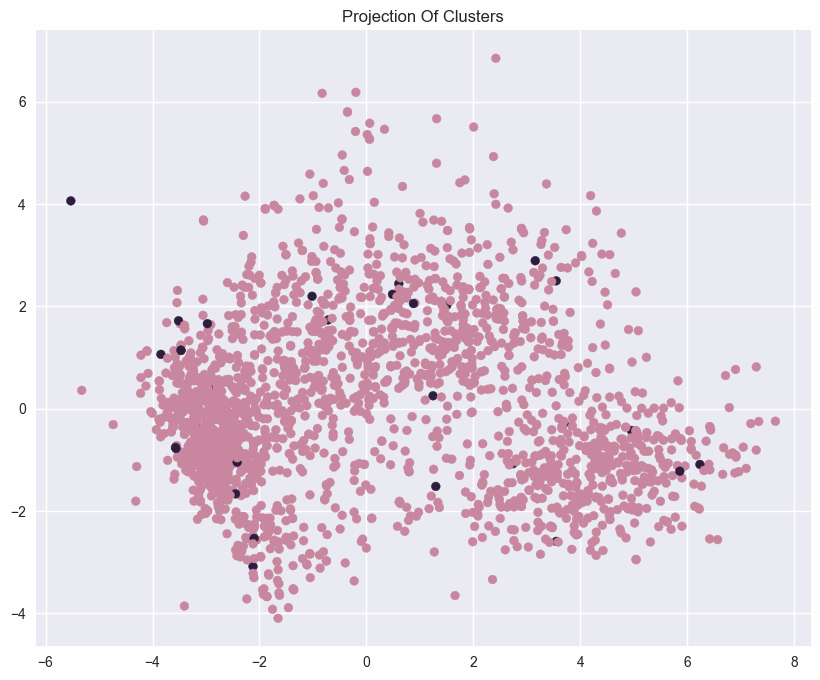

In [18]:
cmap = colors.ListedColormap(["#2d1e3e", "#c8879e"])

# Plotting the clusters
fig = plt.figure(figsize=(10,8))
# ax = plt.subplot(111, projection='3d', label="bla")
ax = plt.subplot(111, label="bla")
ax.scatter(x, y, s=40, c=pca_result["DBSCAN_Clusters"], marker='o', cmap = cmap)
ax.set_title("Projection Of Clusters")
plt.show()

Drop outliers

In [19]:
input_df = input_df[input_df['DBSCAN_Clusters'] != -1]
pca_result = pca_result[pca_result['DBSCAN_Clusters'] != -1]
df = df[df['DBSCAN_Clusters'] != -1]

In [20]:
pca_result['DBSCAN_Clusters'].value_counts()

DBSCAN_Clusters
0    2196
Name: count, dtype: int64

### Find optimal k
Ta xác định số cluster tối ưu bằng cách sử dụng kỹ thuật Elbow Method.

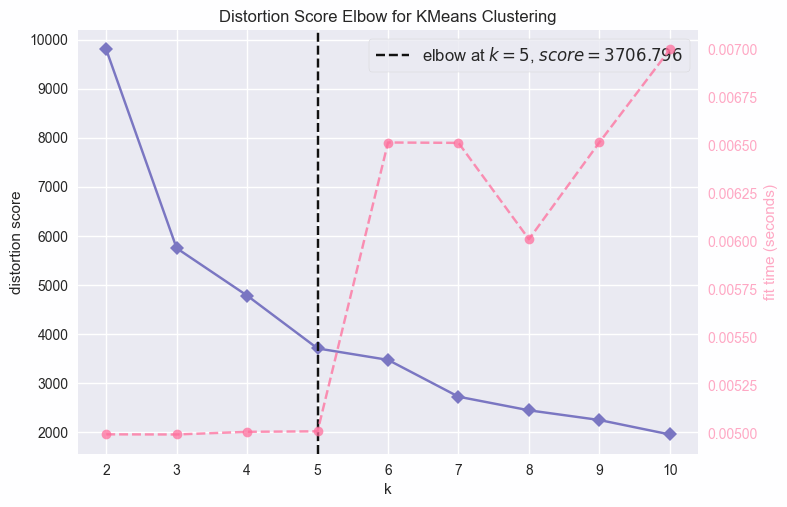

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
# Use elbow method to find optimal cluster number.
elbow = KElbowVisualizer(KMeans(), k=10, random_state=18)
elbow.fit(pca_result)
elbow.show()

## Model Comparision

### K-Means

In [22]:
# Initiate KMeans
kmeans_model = KMeans(n_clusters=4, random_state=18)

# Fit model
kmeans_model.fit(pca_result)

# Predict
km_cluster_labels = kmeans_model.predict(pca_result)

# Calculate index and score
km_silhouette = silhouette_score(pca_result, km_cluster_labels)
km_db_index = davies_bouldin_score(pca_result, km_cluster_labels)
km_ch_score = calinski_harabasz_score(pca_result, km_cluster_labels)

# Inertia
km_inertia = kmeans_model.inertia_

pca_result['KM_Clusters'] = km_cluster_labels
input_df['KM_Clusters'] = km_cluster_labels

print(f"Inertia: {km_inertia}")

Inertia: 4566.504316952701


### Agglomerative Clustering Model

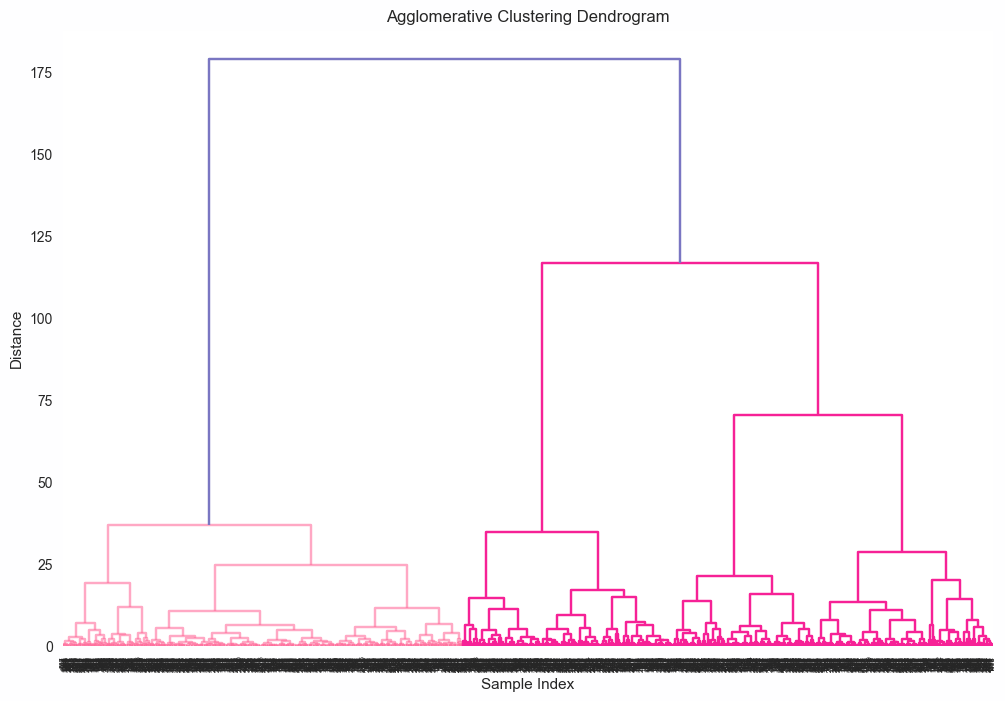

In [23]:
#Set up the model
ac_model = AgglomerativeClustering(n_clusters=4)
# Fit model and predict clusters
ac_cluster_labels = ac_model.fit_predict(pca_result)

ac_silhouette = silhouette_score(pca_result, ac_cluster_labels)

ac_db_index = davies_bouldin_score(pca_result, ac_cluster_labels)

ac_ch_score = calinski_harabasz_score(pca_result, ac_cluster_labels)

pca_result['AC_Clusters'] = ac_cluster_labels
input_df['AC_Clusters'] = ac_cluster_labels

# Draw dendrogram for Agglomerative Clustering
plt.figure(figsize=(12, 8))
linked = linkage(pca_result, method='ward')
dendrogram(linked)
plt.title('Agglomerative Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [24]:
# Create table
evaluation_results = [
    ['KMeans', km_silhouette, km_db_index, km_ch_score],
    ['Agglomerative Clustering', ac_silhouette, ac_db_index, ac_ch_score]
]

print(tabulate(evaluation_results, headers=['Model', 'Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Index'], tablefmt='grid'))


+--------------------------+--------------------+------------------------+---------------------------+
| Model                    |   Silhouette Score |   Davies-Bouldin Index |   Calinski-Harabasz Index |
+==========================+====================+========================+===========================+
| KMeans                   |           0.455638 |               0.855567 |                   3191.82 |
+--------------------------+--------------------+------------------------+---------------------------+
| Agglomerative Clustering |           0.526953 |               0.77084  |                   3499.92 |
+--------------------------+--------------------+------------------------+---------------------------+


Silhouette Score:
- Gần 1: Các điểm được phân cụm đúng cách, khoảng cách trong cụm nhỏ và khoảng cách giữa các cụm lớn.
- Gần 0: Các điểm nằm gần ranh giới giữa các cụm.
- Gần -1: Các điểm có thể đã bị phân cụm sai.

Davies_Bouldin Index: Giá trị nhỏ hơn cho thấy phân cụm tốt, các cụm có khoảng cách lớn giữa nhau và các điểm trong cùng một cụm gần nhau hơn.

Calinski-Harabasz Index (Variance Ratio Criterion): Giá trị lớn hơn cho thấy phân cụm tốt, các cụm có sự phân tán lớn giữa các cụm và sự phân tán nhỏ trong các cụm.

In [25]:
# 3D Projection
x = pca_result["d1"]
y = pca_result["d2"]

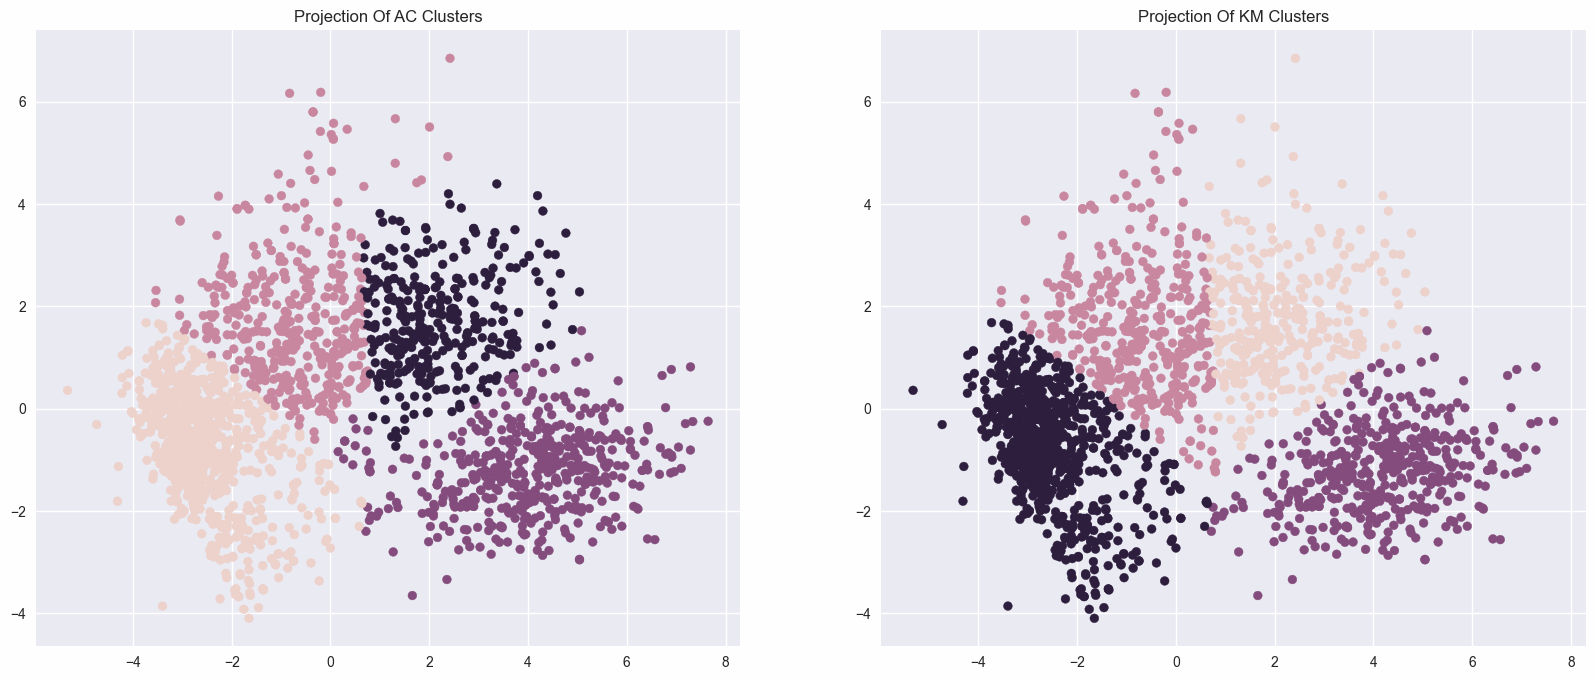

In [26]:
from matplotlib import colors
# Set colors
cmap = colors.ListedColormap(["#edd1cb","#c8879e", "#834c7d","#2d1e3e"])

# Create figure and subplots
fig = plt.figure(figsize=(20, 8))

# AC Cluster 3D projection
ax1 = fig.add_subplot(121)
ax1.scatter(x, y, s=40, c=pca_result["AC_Clusters"], marker='o', cmap=cmap)
ax1.set_title("Projection Of AC Clusters")

# KM Cluster 3D projection
ax2 = fig.add_subplot(122)
ax2.scatter(x, y, s=40, c=pca_result["KM_Clusters"], marker='o', cmap=cmap)
ax2.set_title("Projection Of KM Clusters")

plt.show()

## Hyperparameter tunning

In [27]:
# Define the parameter grid for affinity, linkage, distance_threshold, and compute_distances
param_grid = {
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'linkage': ['ward', 'complete', 'average', 'single'],
    'distance_threshold': [None, 175, 180, 185],  # Example values, adjust based on your data
    'compute_distances': [True, False]
}

best_score_silhouette = -1
best_score_db = np.inf
best_score_ch = -1
best_params = None

# Perform grid search over the parameter grid
for metric in param_grid['metric']:
    for linkage in param_grid['linkage']:
        for distance_threshold in param_grid['distance_threshold']:
            for compute_distances in param_grid['compute_distances']:
                if linkage == 'ward' and metric != 'euclidean':
                    # Ward linkage only works with Euclidean metric
                    continue
                
                print(f"Testing combination: Affinity = {metric}, Linkage = {linkage}, "
                      f"Distance Threshold = {distance_threshold}, Compute Distances = {compute_distances}")
                
                try:
                    model = AgglomerativeClustering(
                        n_clusters=None if distance_threshold is not None else 4,
                        metric=metric,
                        linkage=linkage,
                        distance_threshold=distance_threshold,
                        compute_distances=compute_distances
                    )
                    labels = model.fit_predict(pca_result)
                    silhouette = silhouette_score(pca_result, labels)
                    db = davies_bouldin_score(pca_result, labels)
                    ch = calinski_harabasz_score(pca_result, labels)
                
                    # Choose parameters based on multiple criteria
                    if (silhouette > best_score_silhouette) or \
                       (silhouette == best_score_silhouette and db < best_score_db) or \
                       (silhouette == best_score_silhouette and db == best_score_db and ch > best_score_ch):
                        best_score_silhouette = silhouette
                        best_score_db = db
                        best_score_ch = ch
                        best_params = {
                            'metric': metric,
                            'linkage': linkage,
                            'distance_threshold': distance_threshold,
                            'compute_distances': compute_distances
                        }
                        
                except Exception as e:
                    print(f"Failed to fit model with Affinity = {metric}, Linkage = {linkage}, "
                          f"Distance Threshold = {distance_threshold}, Compute Distances = {compute_distances}. "
                          f"Error: {str(e)}")

print("")
print(f"Best Silhouette Score: {best_score_silhouette}")
print(f"Best Davies-Bouldin Index: {best_score_db}")
print(f"Best Calinski-Harabasz Index: {best_score_ch}")
print(f"Best Parameters:{best_params}")

Testing combination: Affinity = euclidean, Linkage = ward, Distance Threshold = None, Compute Distances = True
Testing combination: Affinity = euclidean, Linkage = ward, Distance Threshold = None, Compute Distances = False
Testing combination: Affinity = euclidean, Linkage = ward, Distance Threshold = 175, Compute Distances = True
Testing combination: Affinity = euclidean, Linkage = ward, Distance Threshold = 175, Compute Distances = False
Testing combination: Affinity = euclidean, Linkage = ward, Distance Threshold = 180, Compute Distances = True
Failed to fit model with Affinity = euclidean, Linkage = ward, Distance Threshold = 180, Compute Distances = True. Error: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)
Testing combination: Affinity = euclidean, Linkage = ward, Distance Threshold = 180, Compute Distances = False
Failed to fit model with Affinity = euclidean, Linkage = ward, Distance Threshold = 180, Compute Distances = False. Error: Number of labels is

In [30]:
model = AgglomerativeClustering(n_clusters=4, metric=best_params['metric'], linkage=best_params['linkage'])
labels = model.fit_predict(pca_result)
score = silhouette_score(pca_result, labels)

pca_result['Clusters'] = labels
input_df['Clusters'] = labels
df['Clusters'] = labels

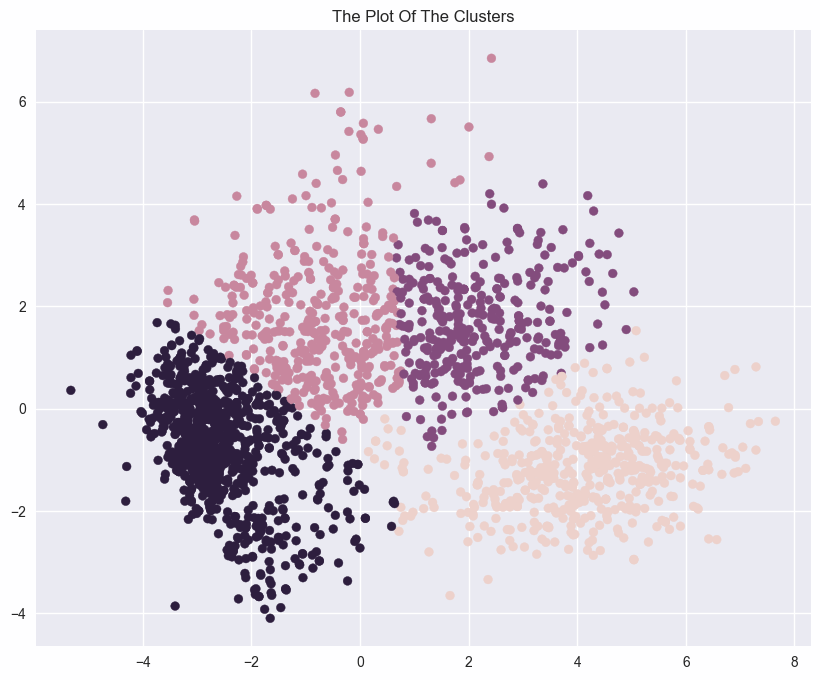

In [31]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, label="bla")
ax.scatter(x, y, s=40, c=pca_result["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

-------------

In [32]:
input_df.columns

Index(['Income', 'Recency', 'Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy',
       'Jewellery', 'Num_Deals_Purchases', 'Num_Web_Purchases',
       'Num_Catalog_Purchases', 'Num_Store_Purchases', 'Num_Web_Visits_Month',
       'Complain', 'Total_Purchase', 'Total_Expense', 'Age', 'Marital_Status',
       'Children', 'Family_Size', 'Is_Parent', 'Academic_Level',
       'Customer_For', 'Promo_Response', 'DBSCAN_Clusters', 'KM_Clusters',
       'AC_Clusters', 'Clusters'],
      dtype='object')

# Profiling

In [33]:
df['Academic_Level'] = input_df['Academic_Level']
df['Marital_Status'] = input_df['Marital_Status']

### Cluster distribution

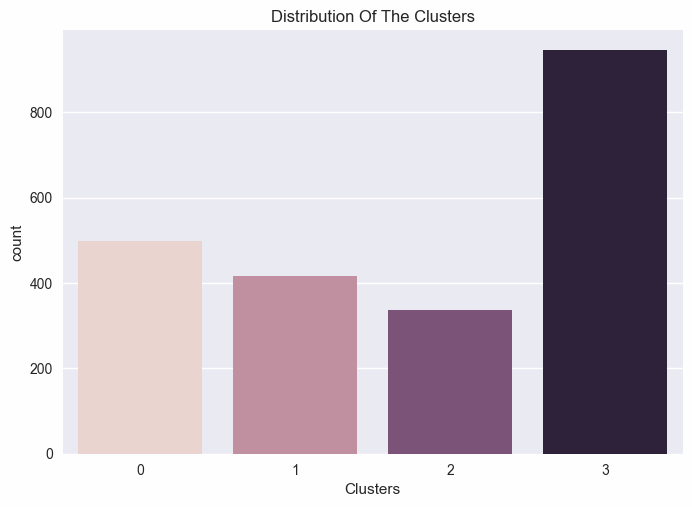

In [34]:
# Draw plot
palette = ["#edd1cb","#c8879e", "#834c7d","#2d1e3e"]
dist_cluster = sns.countplot(x = df["Clusters"], palette = palette)
dist_cluster.set_title("Distribution Of The Clusters")
plt.show()

### Correlation between Total_Expense and Income

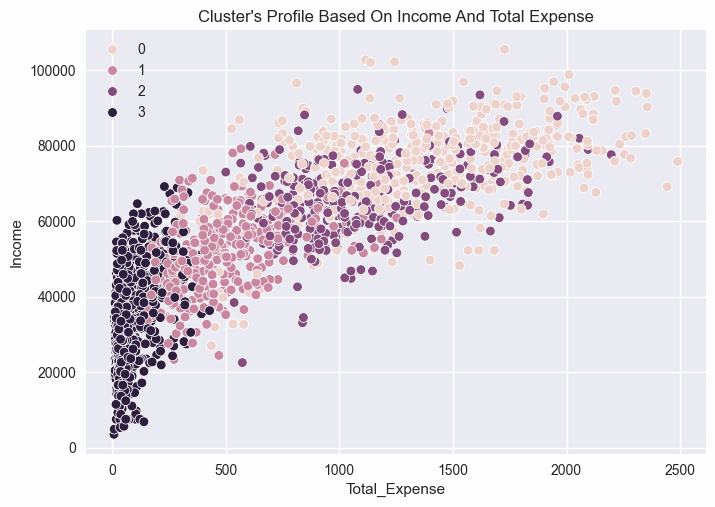

In [35]:
# Draw plot
scat_cluster = sns.scatterplot(data = df, x="Total_Expense", y="Income",hue="Clusters")
scat_cluster.set_title("Cluster's Profile Based On Income And Total Expense")
plt.legend()
plt.show()

### Total_Expense boxplot by each Cluster

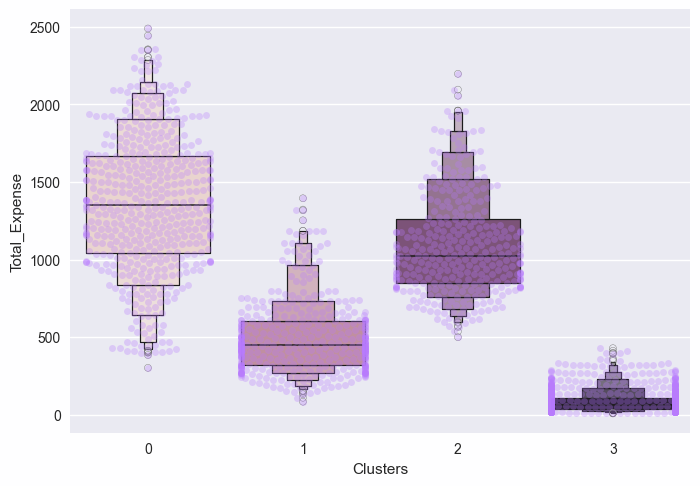

In [36]:
plt.figure()
plot=sns.swarmplot(x=df["Clusters"], y=df["Total_Expense"], color= "#b87bff", alpha=0.3 )
plot=sns.boxenplot(x=df["Clusters"], y=df["Total_Expense"], palette=palette)
plt.show()

### Promo response by each cluster

In [37]:
df['Is_Response'] = df['Promo_Response'].apply(lambda x: 0 if x == 0 else 1)

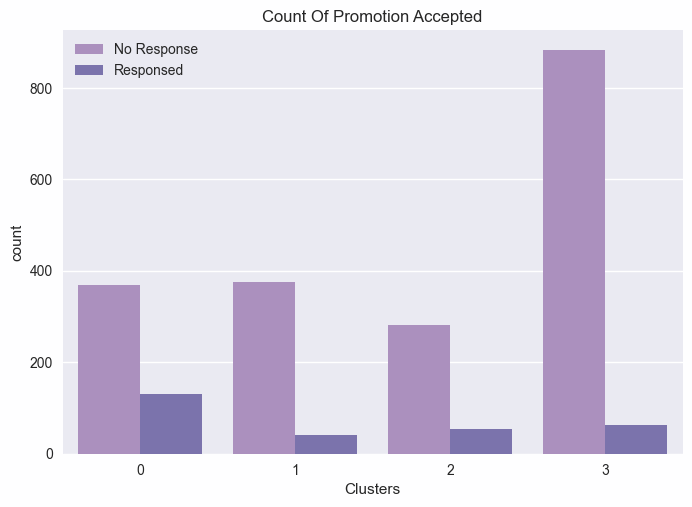

In [38]:
palette1 = ["#AD88C6","#7469B6"]

plt.figure()
plot = sns.countplot(x=df["Clusters"], hue=df["Is_Response"], palette=palette1)

plot.set_title("Count Of Promotion Accepted")
plot.set_xlabel("Clusters")

new_labels = ['No Response', 'Responsed']
for t, l in zip(plot.legend().texts, new_labels):
    t.set_text(l)

plt.show()

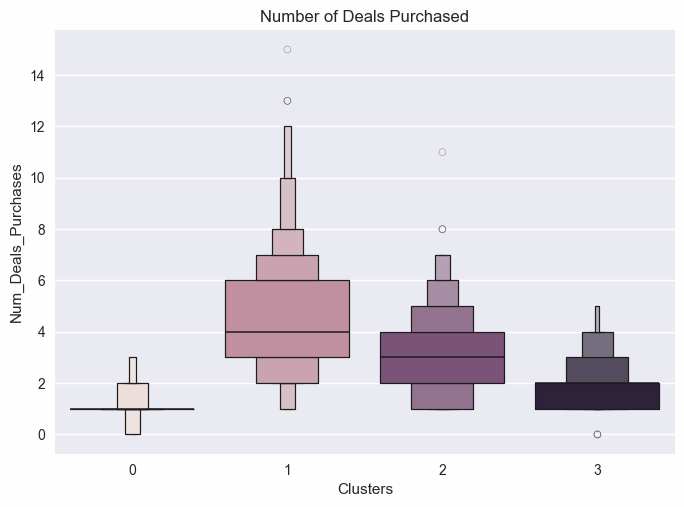

In [39]:
#Plotting the number of deals purchased
plt.figure()
plot=sns.boxenplot(y=df["Num_Deals_Purchases"],x=df["Clusters"], palette= palette)
plot.set_title("Number of Deals Purchased")
plt.show()

In [40]:
personal_info = ['Children', 'Customer_For', 'Age', 'Family_Size', 'Is_Parent', 'Academic_Level', 'Marital_Status']

<Figure size 800x550 with 0 Axes>

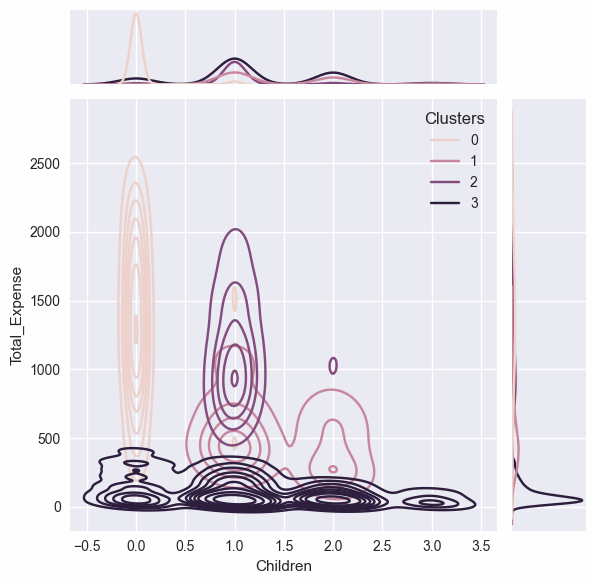

<Figure size 800x550 with 0 Axes>

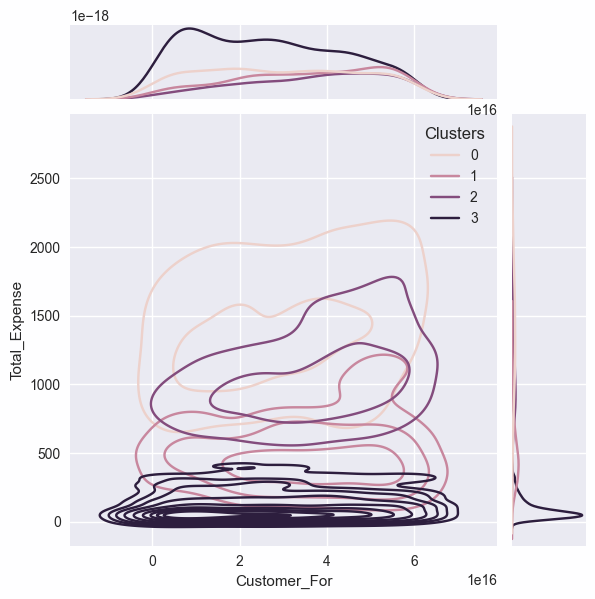

<Figure size 800x550 with 0 Axes>

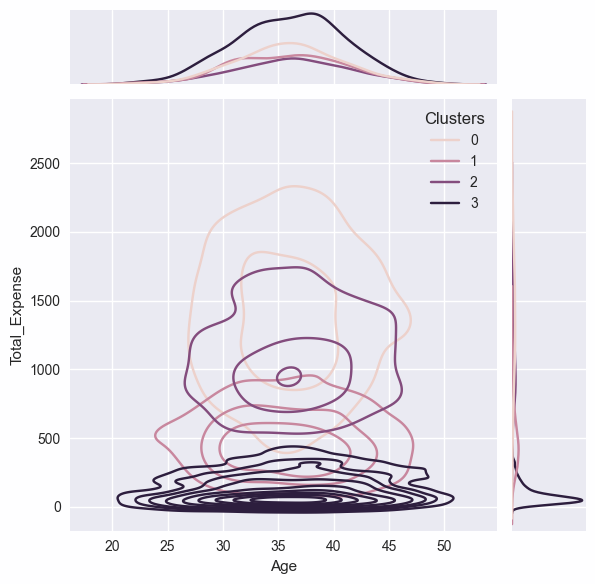

<Figure size 800x550 with 0 Axes>

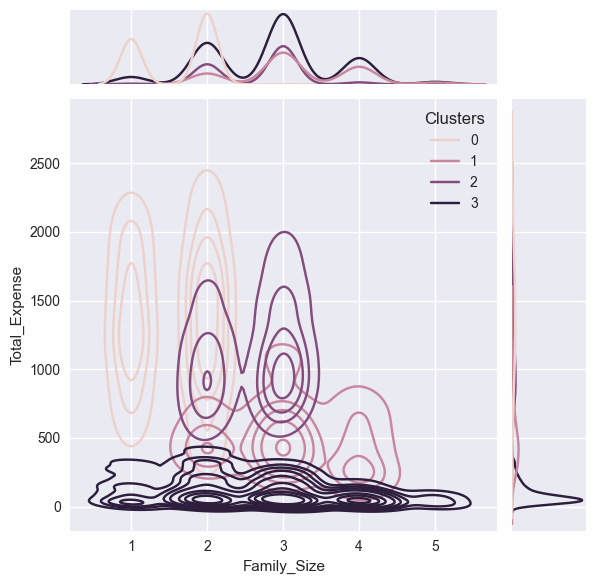

<Figure size 800x550 with 0 Axes>

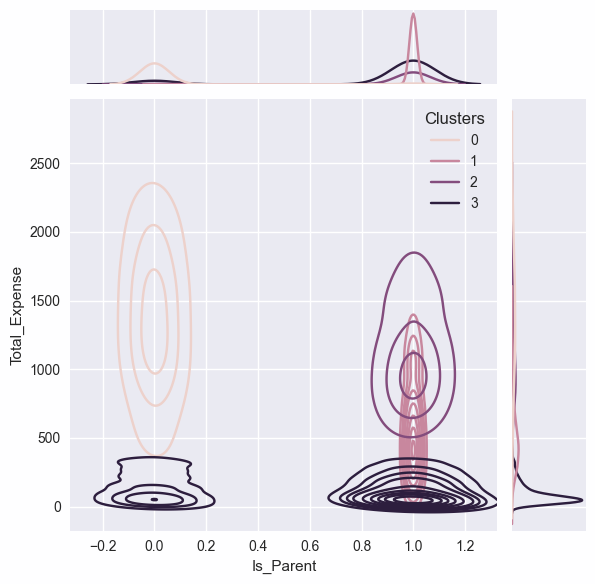

<Figure size 800x550 with 0 Axes>

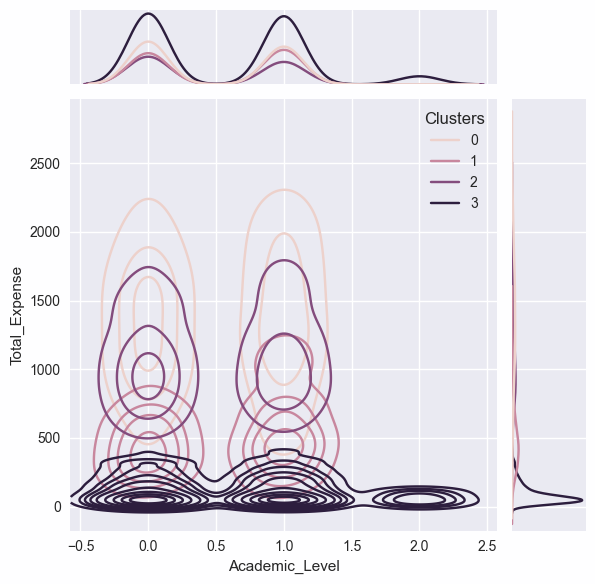

<Figure size 800x550 with 0 Axes>

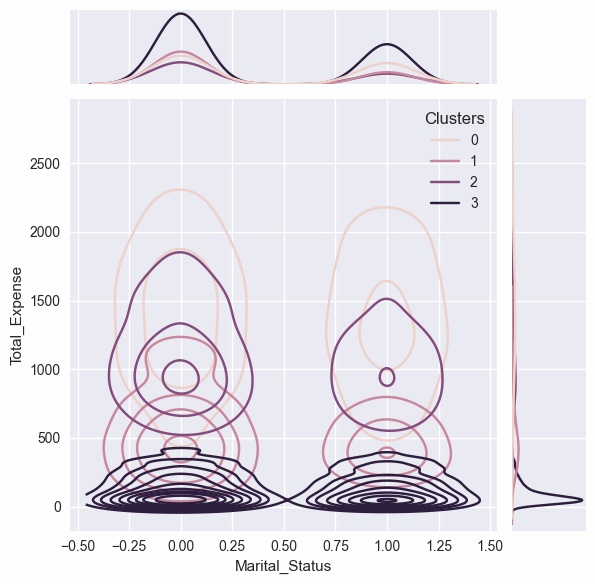

In [41]:
for i in personal_info:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Total_Expense"], hue =df["Clusters"], kind="kde", palette=palette)
    plt.show()

# Testing

## Promo

### A/B Testing

In [42]:
input_df.columns

Index(['Income', 'Recency', 'Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy',
       'Jewellery', 'Num_Deals_Purchases', 'Num_Web_Purchases',
       'Num_Catalog_Purchases', 'Num_Store_Purchases', 'Num_Web_Visits_Month',
       'Complain', 'Total_Purchase', 'Total_Expense', 'Age', 'Marital_Status',
       'Children', 'Family_Size', 'Is_Parent', 'Academic_Level',
       'Customer_For', 'Promo_Response', 'DBSCAN_Clusters', 'KM_Clusters',
       'AC_Clusters', 'Clusters'],
      dtype='object')

In [43]:
promo_test = df[['Promo_30', 'Promo_40', 'Promo_50', 'Promo_10', 'Promo_20', 'Promo_Response', 'Total_Expense']]

no_promo = promo_test[promo_test['Promo_Response'] == 0]['Total_Expense']
with_promo = promo_test[promo_test['Promo_Response'] > 0]['Total_Expense']

In [44]:
from scipy.stats import ttest_ind

# Execute t-test
t_statistic, p_value = ttest_ind(with_promo, no_promo)

# Print result
print("T-statistic:", t_statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("Significant difference.")
else:
    print("No significant difference.")

T-statistic: 13.492328902349787
P-value: 6.4741988842254385e-40
Significant difference.


### Linear Regression

In [45]:
import statsmodels.api as sm

# Create dependent and independent variables
X = promo_test[['Promo_10', 'Promo_20', 'Promo_30', 'Promo_40', 'Promo_50']]
y = promo_test['Total_Expense']

# Add constant
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

# Print result
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Total_Expense   R-squared:                       0.149
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     95.96
Date:                Sun, 02 Jun 2024   Prob (F-statistic):           2.59e-75
Time:                        23:19:40   Log-Likelihood:                -16977.
No. Observations:                2196   AIC:                         3.396e+04
Df Residuals:                    2191   BIC:                         3.399e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        544.2102     12.599     43.195      0.0

## Marital Status
### A/B testing

In [46]:
input_df

,Income,Recency,Liquor,Vegetables,Pork,Seafood,Candy,Jewellery,Num_Deals_Purchases,Num_Web_Purchases,...,Children,Family_Size,Is_Parent,Academic_Level,Customer_For,Promo_Response,DBSCAN_Clusters,KM_Clusters,AC_Clusters,Clusters
0,30396.0,22,16.0,2.0,6.0,0.0,1.0,12.0,2,1,...,1,3,1,1,5184000000000000,1,0,3,0,3
1,68682.0,56,920.0,2.0,505.0,99.0,30.0,45.0,1,4,...,0,2,0,1,22982400000000000,0,0,2,2,0
2,63516.0,30,142.0,13.0,114.0,15.0,14.0,5.0,4,4,...,2,4,1,1,30931200000000000,0,0,1,1,1
3,72679.0,65,620.0,56.0,260.0,127.0,54.0,54.0,1,4,...,1,2,1,0,24537600000000000,0,0,2,2,0
4,66334.0,82,910.0,13.0,218.0,0.0,0.0,23.0,2,9,...,1,3,1,1,39052800000000000,0,0,0,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2223,71964.0,81,588.0,53.0,932.0,180.0,34.0,86.0,1,5,...,0,1,0,0,34992000000000000,0,0,2,2,0
2224,59354.0,53,234.0,4.0,53.0,3.0,5.0,14.0,3,6,...,2,3,1,1,19526400000000000,0,0,1,1,1
2225,82032.0,54,333.0,196.0,377.0,149.0,125.0,57.0,0,4,...,0,1,0,1,7344000000000000,0,0,2,2,0
2226,38361.0,74,40.0,2.0,56.0,20.0,8.0,14.0,3,3,...,1,3,1,0,15897600000000000,0,0,3,0,3


In [47]:
marital_test = df[['Marital_Status', 'Complain']]
marital_test['Marital_Status'] = marital_test['Marital_Status'].apply(lambda x: 1 if x == 'Relationship' else 0)

In [48]:
no_rel = marital_test[marital_test['Marital_Status'] == 0]['Complain']
with_rel = marital_test[marital_test['Marital_Status'] == 1]['Complain']

In [49]:
# Execute t-test
t_statistic, p_value = ttest_ind(with_rel, no_rel)

# Print result
print("T-statistic:", t_statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("Significant difference.")
else:
    print("No significant difference.")

T-statistic: nan
P-value: nan
No significant difference.


## Num_Web_Purchase
### A/B testing

In [50]:
web_test = df[['Num_Web_Purchases', 'Total_Purchase']]
web_test['Is_Purchase_Onl'] = web_test['Num_Web_Purchases'].apply(lambda x: 1 if x > 0 else 0)

In [51]:
no_web = web_test[web_test['Is_Purchase_Onl'] == 0]['Total_Purchase']
with_web = web_test[web_test['Is_Purchase_Onl'] == 1]['Total_Purchase']

In [52]:
# Execute t-test
t_statistic, p_value = ttest_ind(with_web, no_web)

# Print result
print("T-statistic:", t_statistic)
print("P-value:", p_value)

if p_value < 0.05:
    print("Significant difference.")
else:
    print("No significant difference.")

T-statistic: 9.359105608817677
P-value: 1.9216033850522372e-20
Significant difference.


# Extension

In [53]:
df.columns

Index(['ID', 'Year_Of_Birth', 'Income', 'Registration_Time', 'Recency',
       'Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy', 'Jewellery',
       'Num_Deals_Purchases', 'Num_Web_Purchases', 'Num_Catalog_Purchases',
       'Num_Store_Purchases', 'Num_Web_Visits_Month', 'Promo_30', 'Promo_40',
       'Promo_50', 'Promo_10', 'Promo_20', 'Complain', 'Gender',
       'Total_Purchase', 'Payment_Method', 'Phone', 'Total_Expense', 'Age',
       'Marital_Status', 'Children', 'Family_Size', 'Is_Parent',
       'Academic_Level', 'Customer_For', 'Promo_Response', 'DBSCAN_Clusters',
       'Clusters', 'Is_Response'],
      dtype='object')

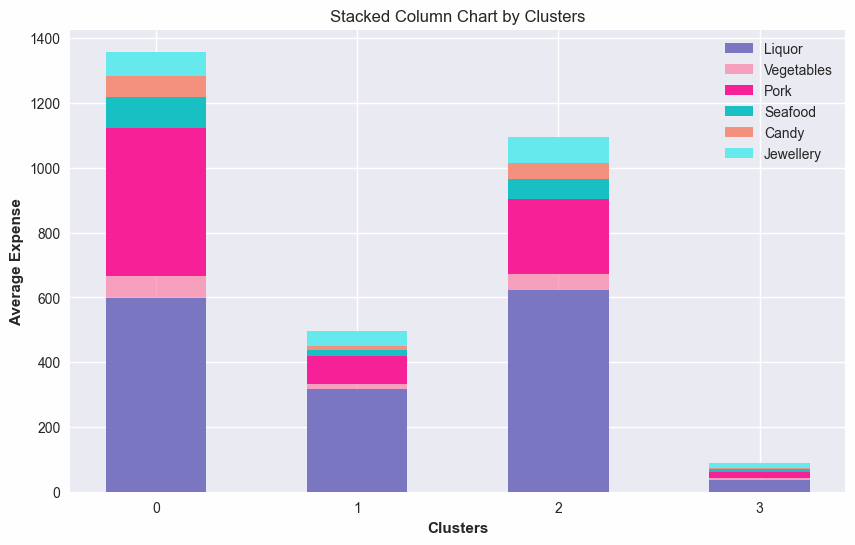

In [54]:
# Group by cluster and calculate mean value
df_grouped = df.groupby('Clusters')[['Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy', 'Jewellery']].mean().reset_index()

clusters = df_grouped['Clusters']
liquor = df_grouped['Liquor']
vegetables = df_grouped['Vegetables']
pork = df_grouped['Pork']
seafood = df_grouped['Seafood']
candy = df_grouped['Candy']
jewellery = df_grouped['Jewellery']


fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.5
r1 = np.arange(len(clusters))
ax.bar(r1, liquor, width=bar_width, label='Liquor')
ax.bar(r1, vegetables, bottom=liquor, width=bar_width, label='Vegetables')
ax.bar(r1, pork, bottom=liquor+vegetables, width=bar_width, label='Pork')
ax.bar(r1, seafood, bottom=liquor+vegetables+pork, width=bar_width, label='Seafood')
ax.bar(r1, candy, bottom=liquor+vegetables+pork+seafood, width=bar_width, label='Candy')
ax.bar(r1, jewellery, bottom=liquor+vegetables+pork+seafood+candy, width=bar_width, label='Jewellery')

ax.set_xlabel('Clusters', fontweight='bold')
ax.set_ylabel('Average Expense', fontweight='bold')
ax.set_title('Stacked Column Chart by Clusters')
ax.set_xticks(r1)
ax.set_xticklabels(clusters)

ax.legend()

plt.show()

In [55]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Transaction Encoding
basket_sets = df[['Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy', 'Jewellery']].applymap(lambda x: 1 if x > 0 else 0)

# Apriori Algorithm
frequent_itemsets = apriori(basket_sets, min_support=0.50, use_colnames=True)

# Association Rule Mining
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Filter rules where both antecedents and consequents have only one item
filtered_rules = rules[(rules['antecedents'].apply(lambda x: len(x) == 1)) & (rules['consequents'].apply(lambda x: len(x) == 1))]

# Filter rules relevant to our items
relevant_rules = filtered_rules[
    filtered_rules['antecedents'].apply(lambda x: list(x)[0] in ['Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy', 'Jewellery']) 
    & filtered_rules['consequents'].apply(lambda x: list(x)[0] in ['Liquor', 'Vegetables', 'Pork', 'Seafood', 'Candy', 'Jewellery'])
]

# Display rules
relevant_columns = ['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence', 'lift']

# Select only the relevant columns from the filtered rules DataFrame
relevant_rules = filtered_rules[relevant_columns]

# Convert frozenset to string, remove parentheses, and convert back to frozenset
relevant_rules['antecedents'] = relevant_rules['antecedents'].apply(lambda x: str(list(x))[2:-2])
relevant_rules['consequents'] = relevant_rules['consequents'].apply(lambda x: str(list(x))[2:-2])
relevant_rules.sort_values('antecedents')

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
23,Candy,Jewellery,0.811475,0.972222,0.795993,0.980920,1.008947
19,Candy,Seafood,0.811475,0.828780,0.732240,0.902357,1.088778
14,Candy,Vegetables,0.811475,1.000000,0.811475,1.000000,1.000000
7,Candy,Liquor,0.811475,1.000000,0.811475,1.000000,1.000000
21,Jewellery,Seafood,0.972222,0.828780,0.811020,0.834192,1.006531
16,Jewellery,Vegetables,0.972222,1.000000,0.972222,1.000000,1.000000
22,Jewellery,Candy,0.972222,0.811475,0.795993,0.818735,1.008947
9,Jewellery,Liquor,0.972222,1.000000,0.972222,1.000000,1.000000
0,Liquor,Vegetables,1.000000,1.000000,1.000000,1.000000,1.000000
6,Liquor,Candy,1.000000,0.811475,0.811475,0.811475,1.000000


In [56]:
package = relevant_rules.groupby('antecedents')['consequents'].apply(list).reset_index()

package

,antecedents,consequents
0,Candy,"[Liquor, Vegetables, Seafood, Jewellery]"
1,Jewellery,"[Liquor, Vegetables, Seafood, Candy]"
2,Liquor,"[Vegetables, Pork, Seafood, Candy, Jewellery]"
3,Pork,"[Liquor, Vegetables]"
4,Seafood,"[Liquor, Vegetables, Candy, Jewellery]"
5,Vegetables,"[Liquor, Pork, Seafood, Candy, Jewellery]"
